In [1]:
import sys
sys.path.append("..")

from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from egh_vlm.utils import load_phd_dataset

## Analysis

In [2]:
folder_path = "../data/phd"
file_name = "phd_sampled_qwen3_vl_2b.json"

dataset = load_phd_dataset(folder_path, file_name)
df = pd.DataFrame(dataset)
df.head()

Successfully load the PhD dataset with: 10 samples.


,id,question,answer,image_path,label,task,context,hitem,subject,gt,question_gt
0,0,Is any of the shirts in the image gray?,"no, the shirts in the image are white.",../data/phd\images\val2014\COCO_val2014_000000...,0,attribute,"{'icc': 'In a lively living room setting, two ...",gray,shirts,white,0
1,1,Is the monitor screen rectangular in shape?,"yes, the monitor screen is rectangular in shape.",../data/phd\images\val2014\COCO_val2014_000000...,0,attribute,{'icc': 'The monitor screen is circular in sha...,circular,monitor screen,rectangle,1
2,2,Is the floor made of acrylic in the image?,"no, the floor is not made of acrylic. the floo...",../data/phd\images\val2014\COCO_val2014_000000...,0,attribute,{'icc': 'The floor in the image is made of acr...,acrylic,floor,vase,0
3,3,Is the woman wearing black in the image?,"yes, the woman is wearing black. she is wearin...",../data/phd\images\val2014\COCO_val2014_000000...,0,attribute,{'icc': 'The woman in the image is wearing whi...,white,woman,black,1
4,4,Is the back wall made of brick in the image?,"yes, the back wall is made of brick. The brick...",../data/phd\images\val2014\COCO_val2014_000000...,0,attribute,"{'icc': 'In a recent event, two men took the s...",Concrete,back wall,brick,1


In [3]:
label_counts = df['label'].value_counts()
label_counts

label
0    8
1    2
Name: count, dtype: int64

answes lengths mean: 20.0
answer lengths median: 11.5
answer lengths q1: 7.25
answer lengths q3: 28.25


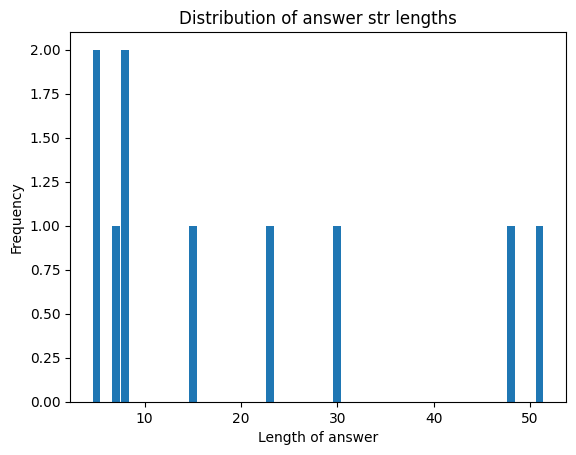

In [4]:
answers = df['answer'].to_list()
answer_legnths = [len(data.split(" ")) for data in answers]
answer_legnths_counts = Counter(answer_legnths)

print(f"answes lengths mean: {round(np.mean(answer_legnths), 2)}")
print(f"answer lengths median: {round(np.median(answer_legnths), 2)}")
print(f"answer lengths q1: {round(np.quantile(answer_legnths, 0.25), 2)}")
print(f"answer lengths q3: {round(np.quantile(answer_legnths, 0.75), 2)}")

plt.figure()
plt.bar(answer_legnths_counts.keys(), answer_legnths_counts.values())
plt.xlabel('Length of answer')
plt.ylabel('Frequency')
plt.title('Distribution of answer str lengths')
plt.show()